[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/ModelEvaluation.ipynb)

# Model Evaluation and Selection

We are going to work a simulated dataset using the following function, which simulates 90 "normal" samples and 90 "cancer" samples from a two-dimensional Gaussian distributions.

Note that the normal samples are sampled from 3 different Gaussian distributions with different means and covariances whereas the cancer samples are sampled from 2 different Gaussian distributions.

In [2]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(1234)

In [3]:
def simulate_prostate_cancer_data():
    # simulate normal samples
    npoints = 30
    means=[70,70]
    #cov = [[90,40],[40,50]]
    cov = [[120,60],[60,50]]
    np.random.seed(3)

    normal1 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal1 = np.zeros((npoints, 1))
    npoints = 30
    means=[140,60]
    #cov = [[90,40],[40,50]]
    cov = [[160,30],[30,50]]

    normal2 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal2 = np.zeros((npoints, 1))

    npoints = 30
    means=[250,110]
    #cov = [[90,40],[40,50]]
    cov = [[300,30],[30,30]]

    normal3 = np.random.multivariate_normal(means,cov, npoints)
    labels_normal3 = np.zeros((npoints, 1))

    normal=np.concatenate((normal1,normal2,normal3))
    labels_normal=np.concatenate((labels_normal1,labels_normal2,labels_normal3))

    # simulate cancer samples
    npoints = 50
    means=[155,80]
    #cov = [[150,50],[50,50]]
    cov = [[4000,-600],[-600,50]]

    cancer1 = np.random.multivariate_normal(means,cov, npoints)
    labels_cancer1 = np.ones((npoints, 1))

    npoints = 40
    means=[50,80]
    #cov = [[150,50],[50,50]]
    cov = [[40,-60],[-60,50]]

    cancer2 = np.random.multivariate_normal(means,cov, npoints)
    labels_cancer2 = np.ones((npoints, 1))

    cancer=np.concatenate((cancer1,cancer2))
    labels_cancer=np.concatenate((labels_cancer1,labels_cancer2))

    X= np.concatenate((normal,cancer), axis=0)
    y = np.concatenate((labels_normal,labels_cancer), axis=0).squeeze() # to (N,)

    return X, y

X,y = simulate_prostate_cancer_data()

/var/folders/jp/b2sr0gz54vj1pmbj1cxq4p5r0000gn/T/ipykernel_20896/2813543773.py:36: RuntimeWarning: covariance is not positive-semidefinite.
  cancer1 = np.random.multivariate_normal(means,cov, npoints)
/var/folders/jp/b2sr0gz54vj1pmbj1cxq4p5r0000gn/T/ipykernel_20896/2813543773.py:44: RuntimeWarning: covariance is not positive-semidefinite.
  cancer2 = np.random.multivariate_normal(means,cov, npoints)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)

We can visualize the simulated data points as follows.

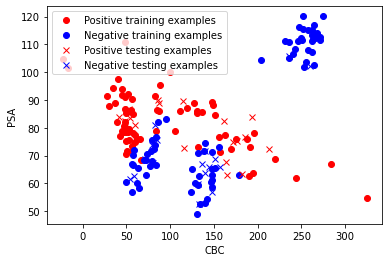

In [5]:
plt.clf()
positive_train = y_train==1
negative_train = y_train==0

positive_test = y_test==1
negative_test = y_test==0

plt.plot(X_train[positive_train,0],X_train[positive_train,1],"or",label="Positive training examples")
plt.plot(X_train[negative_train,0],X_train[negative_train,1],"ob",label="Negative training examples")

plt.plot(X_test[positive_test,0],X_test[positive_test,1],"xr",label="Positive testing examples")
plt.plot(X_test[negative_test,0],X_test[negative_test,1],"xb",label="Negative testing examples")

plt.xlabel("CBC")
plt.ylabel("PSA")
plt.legend(loc='best')
plt.savefig("train_test_scatterplot.png", bbox_inches='tight', dpi=300)

Instead of importing our implementation of `KNN`, to keep things simple, let's use `scikit-learn`'s `KNN` implementation.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier() # n_neighbors=5 (default)
fit = knn.fit(X_train, y_train)

Evaluate the prediction accuracy on training and testing as follows

In [7]:
y_train_pred = fit.predict(X_train)
y_test_pred = fit.predict(X_test)

acc_train = np.sum(y_train_pred==y_train)/len(y_train)
acc_test = np.sum(y_test_pred==y_test)/len(y_test)

print(acc_train)
print(acc_test)

0.9305555555555556
0.9722222222222222


## Generalization error
What we really care about is the performance of the model on new data.
In other words, we want to see how our model **generalizes** to unseen data.
An assumption that justifies deployment of our model on unseen data is the fact that our training and deployment data come from the *same* distribution. In fact very often we assume that there exists some distribution $p(x,y)$ over our features and labels, such that our training data is composed of independent samples from this distribution -- that is $x^{(n)}, y^{(n)} \sim p(x, y)$ for all $x^{(n)}, y^{(n)} \in \mathcal{D}$. We assume that unseen data are also samples from the same distribution.

**Generalization error** is the *expected error* of our model $f: x \mapsto y$ under this distribution:
$$
Err(f) = \mathbb{E}_{x,y \sim p}[\ell(f(x), y)].
$$
Here $\ell$ is some *loss function* such as classification error $\ell(y, \hat{y}) = \mathbb{I}(y = \hat{y})$ or square loss $\ell(y, \hat{y}) = (y - \hat{y})^2$ that we often use in regression.

## Test set
Unfortunately, we don't have access to the true data distribution, we only have samples from this dataset. We can estimate the generalization error by setting aside a portion of our dataset that **we do not using in any way in learning or selecting the model**. This part of the dataset is called the **test set**. Let's use $\mathcal{D}_{\text{train}}$ and $\mathcal{D}_{\text{test}}$ to this partitioning of our original dataset $\mathcal{D}$. The **test error** is
$$
\widehat{Err}(f) = \mathbb{E}_{x, y \sim \mathcal{D}_{\text{test}}}[\ell(f(x), y)] = \frac{1}{|\mathcal{D}_{\text{test}}|} \sum_{x,y \in \mathcal{D}_{\text{test}}} \ell(f(x), y).
$$

## Model selection using validation data

We can split the data twice:
	1. first split the entire data into training and testing set
	2. then split the training data into training and validation set


In [8]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=11)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=11)

Use validation data to choose K in the range from 1 to 10

0.9444444444444444


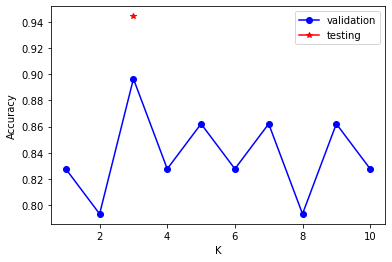

In [9]:
model_choices=[]
valid_acc = []

n_valid = y_valid.shape[0]

for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k) # create a KNN object (OOP)
    knn.fit(X_train, y_train)
    y_valid_pred = knn.predict(X_valid)
    accuracy = np.sum(y_valid_pred == y_valid)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNeighborsClassifier(n_neighbors=best_valid_K)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(test_accuracy)

plt.clf()
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

# plt.show()
plt.savefig("training_validation_testing.png",bbox_inches='tight', dpi=300)

## True/false positive rates

True negative (TN)
* Negative example that is predicted to be negative
* A person who is predicted to be healthy and in fact is healthy

False positive (FP)
* Negative example that is predicted to be positive
* A person who is predicted to have cancer but in fact is healthy

False negative (FN)
* Positive example that is predicted to be negative
* A person who is predicted to be healthy but in fact has cancer

True positive (TP)
* Positive example that is predicted to be positive
* A person who is predicted to have cancer and in fact has cancer

We can compute a confusion matrix that contains TN, FP, FN, and TP as follows.

In [10]:
import pandas as pd
### confusion matrix ###
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

cm_df = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df)

                 Predicted Negative  Predicted Positive
Actual Negative                  22                   0
Actual Positive                   2                  12


0.9444444444444444


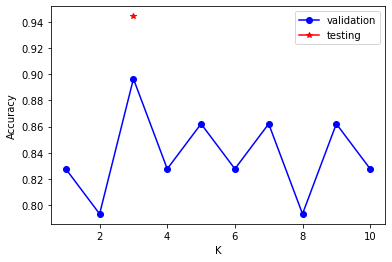

In [11]:
model_choices=[]
valid_acc = []

n_valid = y_valid.shape[0]

for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k) # create a KNN object (OOP)
    knn.fit(X_train, y_train)
    y_valid_pred = knn.predict(X_valid)
    accuracy = np.sum(y_valid_pred == y_valid)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNeighborsClassifier(n_neighbors=best_valid_K)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(test_accuracy)

plt.clf()
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

# plt.show()
plt.savefig("training_validation_testing.png",bbox_inches='tight', dpi=300)

## True/false positive rates

True negative (TN)
* Negative example that is predicted to be negative
* A person who is predicted to be healthy and in fact is healthy

False positive (FP)
* Negative example that is predicted to be positive
* A person who is predicted to have cancer but in fact is healthy

False negative (FN)
* Positive example that is predicted to be negative
* A person who is predicted to be healthy but in fact has cancer

True positive (TP)
* Positive example that is predicted to be positive
* A person who is predicted to have cancer and in fact has cancer

We can compute a confusion matrix that contains TN, FP, FN, and TP as follows.

In [15]:
import pandas as pd
### confusion matrix ###
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

cm_df = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df)

                 Predicted Negative  Predicted Positive
Actual Negative                  22                   0
Actual Positive                   2                  12
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]


## Receiver Operating Characteristic (ROC) Curve

Instead of setting an arbitrary threhold on the probabilities score we can evalaute the method based on *all thresholds* and compute the ROC using the resulting True Postiive Rates (y-axis) and False Positive Rates (x-axis) as follows.

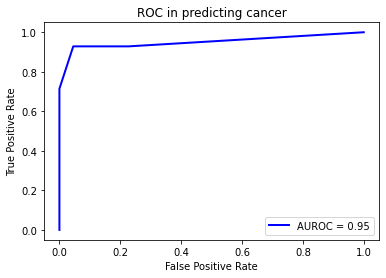

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

knn = KNeighborsClassifier() # create a KNN object (OOP)
knn.fit(X_train, y_train)
# column 0 is healthy
# column 1 is cancer
y_test_prob = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.clf()
plt.plot(fpr, tpr, "b-", lw=2, label="AUROC = %0.2f"%roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC in predicting cancer')
plt.legend(loc="best")
plt.savefig("roc_curve.png",bbox_inches='tight', dpi=300)

In [ ]:
from sklearn.model_selection import KFold

def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    true_labels = np.array([0] * X_input.shape[0])
    pred_scores = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        true_labels[test_index] = Y_output[test_index]
        pred_scores[test_index] = model.predict_proba(X_input[test_index])[:,1]
    return (true_labels, pred_scores)

true_labels,pred_scores = cross_validate(lr_model, X, y)

fpr, tpr, _ = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

plt.text(0.7, 0.3, 'AUC: '+str(round(auc,2)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('../figures/prostate_cancer_lr_crossvalid_roc.eps')


### Method comparison ###
models = [LogisticRegression(solver="liblinear"),
          KNeighborsClassifier(),
          DecisionTreeClassifier()]

perf = {}

for model in models:
    model_name = type(model).__name__
    print(model_name)
    label,pred = cross_validate(model, X, y)
    fpr, tpr, thresholds = roc_curve(label, pred)
    auc = roc_auc_score(label, pred)
    perf[model_name] = {'fpr':fpr,'tpr':tpr,'auc':auc}


fig = plt.figure()

import matplotlib.pyplot as plt

i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],
             label=model_name)
    plt.text(0.4, i, model_name + ': AUC = '+
             str(round(model_perf['auc'],2)))
    i += 0.1

plt.legend(loc='upper center',
           bbox_to_anchor=(0.75, 0.5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('../figures/roc_multimethods.png', bbox_inches='tight', dpi=300)